In [1]:
# KONVOLUCIJSKE NEURONSKE MREŽE ZA KLASIFIKACIJU OBJEKATA
# Lejla Mehinović 


# Učitati sve potrebne pakete
import pandas as pd
import numpy as np
import keras
import os
from sklearn.model_selection import train_test_split
import shutil
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
#Učitati csv dokument
                   #('filepath/HAM10000_metadata.csv')
data = pd.read_csv('C:/Users/Lejla/Desktop/Skin_cancer/HAM10000_metadata.csv')

In [3]:
#Prikazati prvih 5 redaka dokumenta
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
#Prikazati sve stupce dokumenta
data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [5]:
# Dimenzija dokumenta
data.shape

(10015, 7)

In [6]:
#Provjeriti da li neki podaci nedostaju
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [7]:
#Podatke sa null vrijednosti zamijeniti sa mean vrijednosti 
data['age'].fillna((data['age'].mean()), inplace=True)

In [8]:
#Provjeriti da li neki podaci nedostaju
data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [9]:
#Grafički prikazi važnih parametara
#Pomoć za grafičku analizu podataka pronađena je na: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [11]:
#Priprema podataka za klasifikaciju počinje od retka [18]

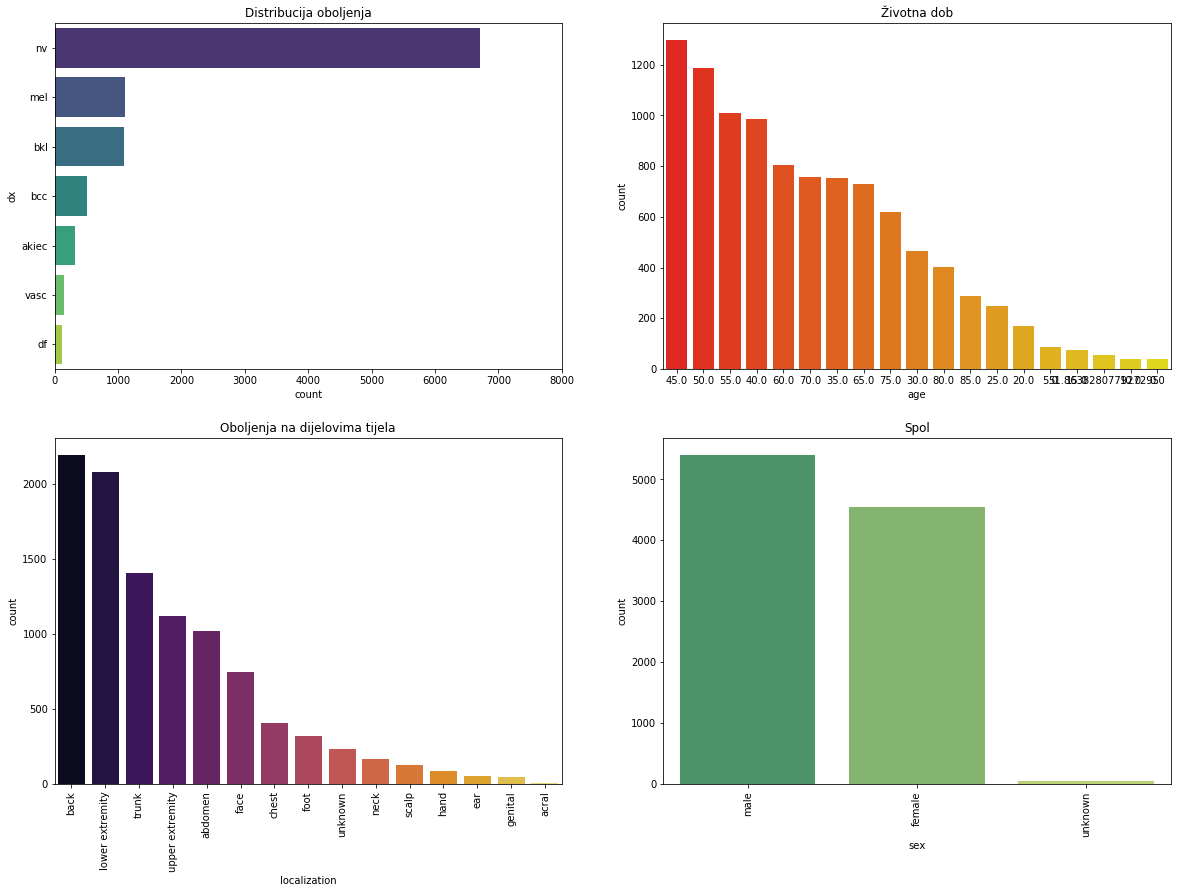

In [12]:
plt.figure(figsize = (20,14))

plt.subplot(2,2,1)
fig = sns.countplot(y = data['dx'], order = data['dx'].value_counts().index, palette= 'viridis')
plt.xticks(fig.get_xticks())
plt.title('Distribucija oboljenja')

plt.subplot(2,2,2)
fig = sns.countplot(x = data['age'], order = data['age'].value_counts().index, palette= 'autumn')
plt.xticks(fig.get_xticks())
plt.title('Životna dob')

plt.subplot(2,2,3)
fig = sns.countplot(x = data['localization'], order = data['localization'].value_counts().index, palette= 'inferno')
plt.xticks(fig.get_xticks(),rotation = 90)
plt.title('Oboljenja na dijelovima tijela')

plt.subplot(2,2,4)
fig = sns.countplot(x = data['sex'], order = data['sex'].value_counts().index, palette= 'summer')
plt.xticks(fig.get_xticks(),rotation = 90)
plt.title('Spol')

# plt.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x2414fc5eac8>,
 <a list of 10 Text xticklabel objects>)

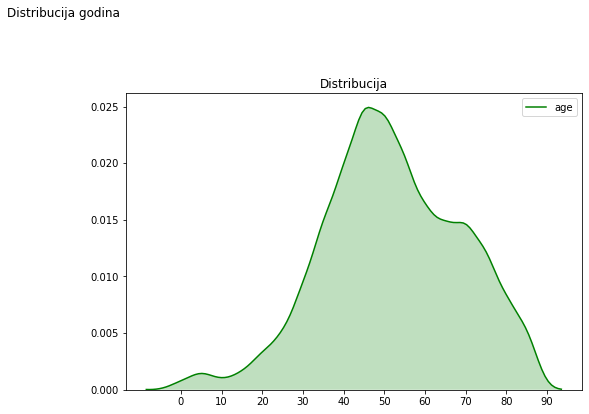

In [13]:
#Distribucija godina

plt.figure(figsize=(18, 12))
plt.suptitle('Distribucija godina')
plt.subplot(2,2,2)
sns.kdeplot(data['age'], shade = True, color = 'green')
plt.title('Distribucija')
plt.xticks(list(range(0,100,10)))

In [14]:
sns.set(color_codes = True)
df= pd.read_csv('C:/Users/Lejla/Desktop/Skin_cancer/HAM10000_metadata.csv')

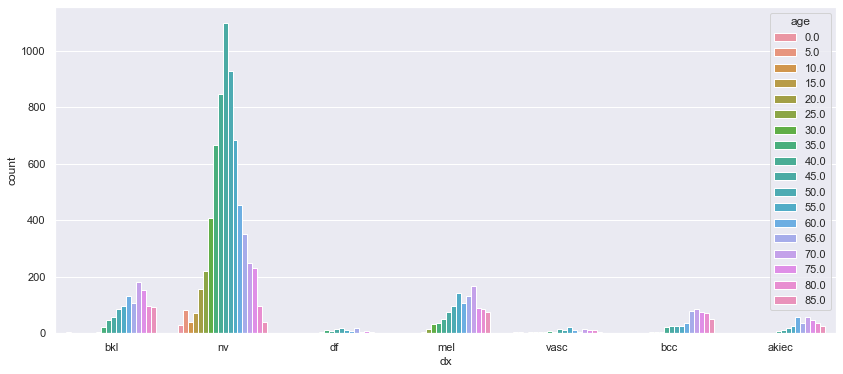

In [15]:
#Korelacija godina i vrste oboljenja
plt.figure(figsize=(14,6))
sns.countplot(x='dx',data=df,hue="age")

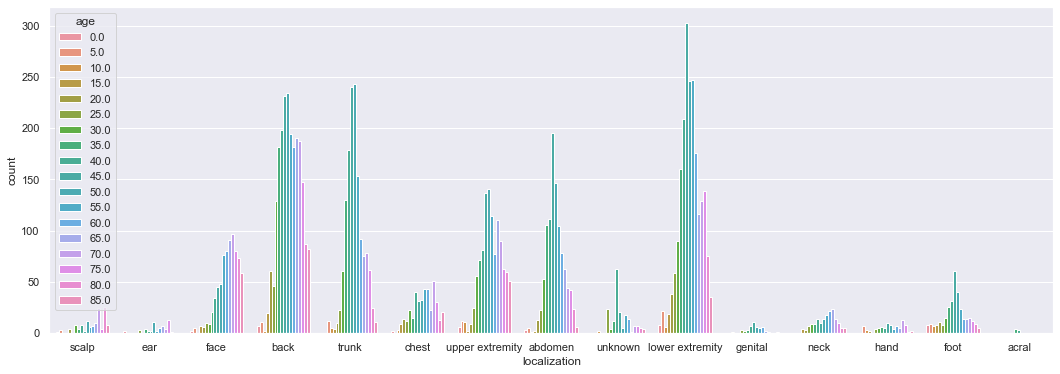

In [16]:
#Korelacija godina i dijelova tijela
plt.figure(figsize=(18,6))
sns.countplot(x='localization',data=df,hue="age")

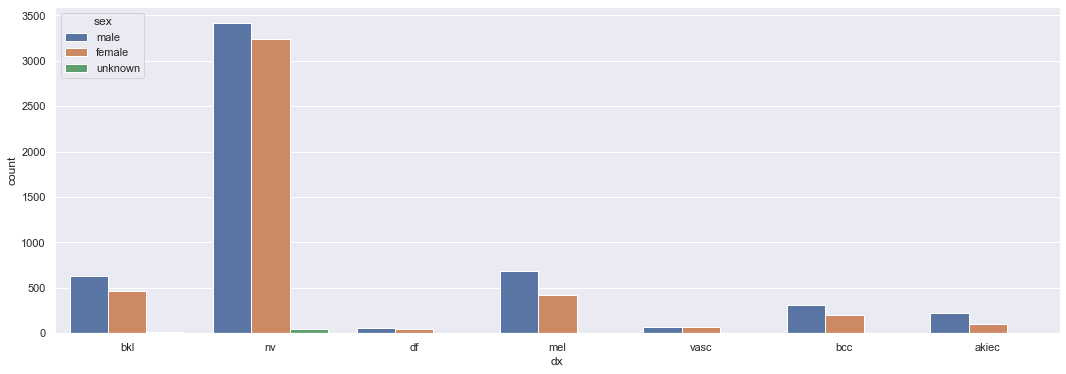

In [17]:
#Korelacija spola i oboljenja
plt.figure(figsize=(18,6))
sns.countplot(x='dx',data=df,hue="sex")

In [ ]:
#PRIPREMA PODATAKA ZA KLASIFIKACIJU

In [10]:
#Kreirati direktorij u koji ćemo smjestiti sve podatke
base_dir = 'base_dir'
os.mkdir(base_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir'

In [11]:
#Kreirati direktorij podataka za treniranje
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir\\train_dir'

In [12]:
# Kreirati direktorij podataka za validaciju
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir\\val_dir'

In [13]:
#Za svaku klasu kreirati direktorij u skupu za treniranje
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir\\train_dir\\nv'

In [14]:
#Za svaku klasu kreirati direktorij u skupu za validaciju
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir\\val_dir\\nv'

In [15]:
# Učitati csv podatke
df = pd.read_csv('C:/Users/Lejla/Desktop/Skin_cancer/HAM10000_metadata.csv')


In [1]:
#Prikazati prvih 5 redaka
df.head()

NameError: name 'df' is not defined

In [17]:
# U varijablu y postaviti kategoriju oboljenje
y = df['dx']

In [18]:
# Podijeliti podatke u skup za treniranje i testiranje
df_train, df_val = train_test_split(df, test_size=0.1, random_state=101, stratify=y)

In [19]:
# Prikazati koliko podataka sadrži skup za treniranje i testiranje
print(df_train.shape)
print(df_val.shape)

(9013, 7)
(1002, 7)


In [20]:
# Prikazati koliko podataka svaka klasa u skupu za treniranje sadrži
df_train['dx'].value_counts()

nv       6034
mel      1002
bkl       989
bcc       463
akiec     294
vasc      128
df        103
Name: dx, dtype: int64

In [21]:
# Prikazati koliko podataka svaka klasa u skupu za validaciju sadrži
df_val['dx'].value_counts()

nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: dx, dtype: int64

In [22]:
#Prebaciti slike u foldere preko parametra image_id koji označava oboljenje
df.set_index('image_id', inplace=True)

In [23]:
# Podaci su smješteni u dva foldera
folder_1 = os.listdir('C:/Users/Lejla/Desktop/Skin_cancer/ham10000_images_part_1')
folder_2 = os.listdir('C:/Users/Lejla/Desktop/Skin_cancer/ham10000_images_part_2')

In [24]:
# Lista podataka za treniranje i testiranje
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [25]:
# Prebaciti podatke za treniranje
for image in train_list:

    fname = image + '.jpg'
    label = df.loc[image, 'dx']

    if fname in folder_1:
        # gdje se slike trenutno nalaze
        src = os.path.join('C:/Users/Lejla/Desktop/Skin_cancer/ham10000_images_part_1', fname)
        # gdje ih treba prebaciti
        dst = os.path.join(train_dir, label, fname)
        # prebaciti slike iz jednog foldera u drugi
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('C:/Users/Lejla/Desktop/Skin_cancer/ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

In [26]:
# Prebaciti podatke za validaciju
for image in val_list:

    fname = image + '.jpg'
    label = df.loc[image, 'dx']

    if fname in folder_1:
        # gdje se slike trenutno nalaze
        src = os.path.join('C:/Users/Lejla/Desktop/Skin_cancer/ham10000_images_part_1', fname)
        # gdje ih treba prebaciti
        dst = os.path.join(val_dir, label, fname)
        # prebaciti slike iz jednog foldera u drugi
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('C:/Users/Lejla/Desktop/Skin_cancer/ham10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

In [27]:
# Koliko slika za treniranje ima u svakoj kategoriji?
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

6034
5810
5984
5606
5930
5170
4170


In [28]:
# Koliko slika za validaciju ima u svakoj kategoriji?
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

671
111
110
51
33
14
12


In [33]:
# Potrebno je augmentirati podatke kako bi imali približno isti broj podataka u svakom folderu
#Augmentirati podatke znači kopirati postojeće uz odgovarajuće izmjene kao što je rotacija
#Klasa nv je izostavljena s obzirom da sadrži 70% ukupnih podataka
class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

In [40]:
for item in class_list:

    # Privremeni direktorij za augmentirane slike
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    #Direktorij u baznom direktoriju u kojem se nalaze slike iste klase
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Klasa
    img_class = item

    # Lista svih slika u direktoriju
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Kopirati slike iz baznog direktorija u img_dir
    for fname in img_list:
       # gdje se slike trenutno nalaze
        src = os.path.join('base_dir/train_dir/' + img_class, fname)
        # gdje ih treba prebaciti
        dst = os.path.join(img_dir, fname)
         # prebaciti slike iz jednog foldera u drugi
        shutil.copyfile(src, dst)

    # direktorij koji sadrži slike
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # generator podataka za augmentiranje
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Augmentirane slike dodati u odgovarajući direktorij
    # Treba nam približno 6000 slika za svaku kategoriju s obzirom da kategorija nv sadrži toliko
    num_aug_images_wanted = 6000 
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))
    
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # izbrisati privremeni direktorij
    shutil.rmtree('aug_dir')

Found 1002 images belonging to 1 classes.
Found 989 images belonging to 1 classes.
Found 463 images belonging to 1 classes.
Found 294 images belonging to 1 classes.
Found 128 images belonging to 1 classes.
Found 103 images belonging to 1 classes.


In [29]:
# Koliko slika za treniranje ima u svakoj kategoriji?
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

6034
5810
5984
5606
5930
5170
4170


In [35]:
# Prikazati koliko podataka svaka klasa u skupu za treniranje sadrži
df_train['dx'].value_counts()

nv       6034
mel      1002
bkl       989
bcc       463
akiec     294
vasc      128
df        103
Name: dx, dtype: int64

In [30]:
# Koliko slika za validaciju ima u svakoj kategoriji?
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

671
111
110
51
33
14
12


In [31]:
#Lokacija foldera za treniranje i validaciju
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

In [32]:
#Varijable potrebne za izgradnju modela
num_train_samples = 9013
num_val_samples = 1002
train_batch_size = 10
val_batch_size = 10
image_size = 224

In [33]:
# Broj koraka u svakoj iteraciji
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [34]:
# Postaviti generatore za model
# U modelu FIPU koristit ćemo MobileNet mrežu
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=10)

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=10)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=10,
    shuffle=False)

Found 38704 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [35]:
#Učitati MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

In [36]:
#Od čega se sastoji mobilenet mreža?
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [37]:
#Model je potrebno modificirati. U ovom slučaju isključit ćemo zadnjih 5 slojeva mreže.
x = mobile.layers[-6].output
# Dodajemo dropout i dense sloj
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

In [38]:
model = Model(inputs=mobile.input, outputs=predictions)

In [39]:
# Od kojih slojeva se sada sastoji model?
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [40]:
# Treniramo zadnja 23 sloja mreže
for layer in model.layers[:-23]:
    layer.trainable = False

In [41]:
# Treniramo model i definiramo Top2 i Top3 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [42]:
# Kompajliramo model i dodajemo Adam optimizator
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [43]:
#Broj podataka za treniranje
num_tr=(len(os.listdir('base_dirS/train_dirS/nv'))+
       len(os.listdir('base_dirS/train_dirS/mel'))+
        len(os.listdir('base_dirS/train_dirS/bkl'))+
        len(os.listdir('base_dirS/train_dirS/bcc'))+
        len(os.listdir('base_dirS/train_dirS/akiec'))+
        len(os.listdir('base_dirS/train_dirS/vasc'))+
        len(os.listdir('base_dirS/train_dirS/df'))
       )
num_tr

38704

In [44]:
#Broj podataka za validaciju
num_val=(len(os.listdir('base_dirS/val_dirS/nv'))+
       len(os.listdir('base_dirS/val_dirS/mel'))+
        len(os.listdir('base_dirS/val_dirS/bkl'))+
        len(os.listdir('base_dirS/val_dirS/bcc'))+
        len(os.listdir('base_dirS/val_dirS/akiec'))+
        len(os.listdir('base_dirS/val_dirS/vasc'))+
        len(os.listdir('base_dirS/val_dirS/df'))
       )
num_val

1002

In [59]:
#Definirajmo težine za svaku kategoriju na način da ih standardziramo

In [60]:
weight_akiec=(1/len(os.listdir('base_dirS/train_dirS/akiec'))*(num_tr/2.0))
weight_akiec

3.263406408094435

In [61]:
weight_bcc=(1/len(os.listdir('base_dirS/train_dirS/bcc'))*(num_tr/2.0))
weight_bcc

3.4520156974669995

In [62]:
weight_bkl=(1/len(os.listdir('base_dirS/train_dirS/bkl'))*(num_tr/2.0))
weight_bkl

3.233957219251337

In [63]:
weight_df=(1/len(os.listdir('base_dirS/train_dirS/df'))*(num_tr/2.0))
weight_df

4.640767386091127

In [64]:
#Melanom neka ima veću težinu s obzirom na njegove karakteristike
weight_mel=((1/len(os.listdir('base_dirS/train_dirS/mel'))*(num_tr/2.0)))*3
weight_mel

9.992426850258177

In [65]:
weight_nv=(1/len(os.listdir('base_dirS/train_dirS/nv'))*(num_tr/2.0))
weight_nv

3.207159429897249

In [66]:
weight_vasc=(1/len(os.listdir('base_dirS/train_dirS/vasc'))*(num_tr/2.0))
weight_vasc

3.7431334622823984

In [58]:
#Težine svake kategorije dodijeljene na odnosu prethodne računice i opasnosti samog oboljenja
class_weights={
    0: 5.263406408094435,  # akiec
    1: 4.4520156974669995,  # bcc
    2: 5.233957219251337,  # bkl
    3: 8.640767386091127,  # df
    4: 9.992426850258177,  # mel
    5: 3.207159429897249,  # nv
    6: 3.7431334622823984,  # vasc
}

In [59]:
# Gdje ćemo spremiti model
filepath = "C:/Users/Lejla/Diplomski rad/model1.h5"

In [60]:
# Spremamo samo najbolju verziju modela dodavajući checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

In [61]:
# Ukoliko učenje stagnira reducirati učenje
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

In [62]:
callbacks_list = [checkpoint, reduce_lr]

In [63]:
# Treniramo model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=5,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/5
902/902 [==============================] - 1231s 1s/step - loss: 4.1377 - categorical_accuracy: 0.7269 - top_2_accuracy: 0.8927 - top_3_accuracy: 0.9620 - val_loss: 1.5465 - val_categorical_accuracy: 0.4900 - val_top_2_accuracy: 0.8084 - val_top_3_accuracy: 0.9301

Epoch 00001: val_top_3_accuracy improved from -inf to 0.93014, saving model to C:/Users/Lejla/Diplomski rad/model1.h5
Epoch 2/5
902/902 [==============================] - 1231s 1s/step - loss: 3.9524 - categorical_accuracy: 0.7334 - top_2_accuracy: 0.9025 - top_3_accuracy: 0.9674 - val_loss: 2.7947 - val_categorical_accuracy: 0.4900 - val_top_2_accuracy: 0.7725 - val_top_3_accuracy: 0.8892

Epoch 00002: val_top_3_accuracy did not improve from 0.93014
Epoch 3/5
902/902 [==============================] - 1239s 1s/step - loss: 3.7841 - categorical_accuracy: 0.7427 - top_2_accuracy: 0.9038 - top_3_accuracy: 0.9696 - val_loss: 4.3621 - val_categorical_accuracy: 0.4601 - val_top_2_accuracy: 0.7505 - val_top_3_accuracy: 0

In [64]:
# Evaluacija modela i zadnje epohe

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.030062701553106308
val_cat_acc: 0.5808383226394653
val_top_2_acc: 0.8273453116416931
val_top_3_acc: 0.9151696562767029


In [65]:
# Konfouzijska matrica
test_labels = test_batches.classes

In [66]:
#Predikcija
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

101/101 [==============================] - 123s 1s/step


In [67]:
# Funkcija koja grafički prikazuje konfuzijsku matricu
def plot_confusion_matrix(cm, classes, normalize=True, title='Konfuzijska matrica', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalizirana konfuzijska matrica")
    else:
        print('Konfuzijska matrica')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Realna klasa')
    plt.xlabel('Klasificiran/a kao')
    plt.tight_layout()


In [68]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [69]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

Normalizirana konfuzijska matrica
[[0.66666667 0.18181818 0.06060606 0.06060606 0.03030303 0.
  0.        ]
 [0.15686275 0.74509804 0.         0.05882353 0.01960784 0.01960784
  0.        ]
 [0.26363636 0.19090909 0.31818182 0.04545455 0.10909091 0.07272727
  0.        ]
 [0.25       0.         0.         0.75       0.         0.
  0.        ]
 [0.17117117 0.13513514 0.04504505 0.06306306 0.38738739 0.1981982
  0.        ]
 [0.0342772  0.11624441 0.01490313 0.07302534 0.12369598 0.63487332
  0.00298063]
 [0.         0.21428571 0.07142857 0.07142857 0.         0.
  0.64285714]]


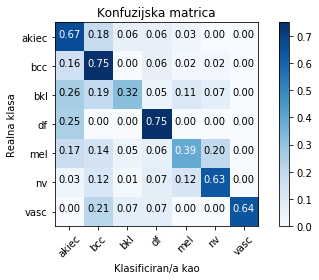

In [70]:
plot_confusion_matrix(cm, cm_plot_labels)

In [71]:
#Spremiti model
model.save("C:/Users/Lejla/Diplomski rad/model1.h5")